In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../')
from ARGUSUtils_Transforms import *

In [2]:
device_num = 0

img1_dir = "../../Data/Final15/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

num_classes = 3

net_dims = 2
net_in_channels = 4

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 48
size_x = 160
size_y = 320

model_filename_base = "./results/BAMC_PTX_ROINet-StdDevExtended-ExtrudedNS-Final15-Full-48s/"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns_image_60','218ns_image_63','219ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

Num images / labels = 47 47


In [3]:
train_files =  []
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in ns_prefix)],
        [se for se in all_labels if any(pref in se for pref in ns_prefix)])
    ])
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in s_prefix)],
        [se for se in all_labels if any(pref in se for pref in s_prefix)])
    ])
train_files.append([
    {"image": img, "label": seg}
    for img, seg in zip(
        [im for im in all_images if any(pref in im for pref in ns_prefix)],
        [se for se in all_labels if any(pref in se for pref in ns_prefix)])
    ])
train_files = list(np.concatenate(train_files).flat)
print(len(train_files))

62


../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/026ns_image_1083297968960_clean.nii.gz
../../Data/Final15/BAMC-PTXNoSliding-Annotations-Linear/026ns_image_1083297968960_clean.extruded-overlay-NS.nii.gz


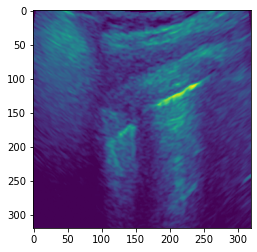

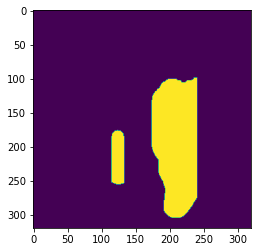

In [4]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[imgnum]["image"])
print(train_files[imgnum]["label"])

img = itk.imread(train_files[imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
train_loader = DataLoader(train_ds, batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr)

Loading dataset: 100%|██████████████████████████| 62/62 [00:07<00:00,  8.38it/s]


torch.Size([16, 4, 160, 320])
torch.Size([4, 160, 320])
image shape: torch.Size([4, 160, 320]), label shape: torch.Size([1, 160, 320])


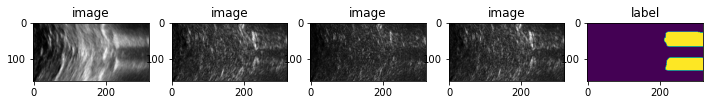

tensor(0.) tensor(1.)


In [7]:
imgnum = 2
check_data = first(train_loader)
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("image")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("image")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("image")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
def net_train(train_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"Epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in train_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2]+metric_values[-3])/3
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'best_model.pth')
                        print("saved new best metric model")
                if epoch == max_epochs // 3:
                    torch.save(model.state_dict(), model_filename_base+'Epoch'+str(epoch)+'_model.pth')
                if epoch == (2*max_epochs) // 3:
                    torch.save(model.state_dict(), model_filename_base+'Epoch'+str(epoch)+'_model.pth')
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'last_model.pth')

    np.save(model_filename_base+"loss.npy", epoch_loss_values)
    np.save(model_filename_base+"val_dice.npy", metric_values)

    

In [10]:
net_train(train_loader)

----------
Epoch 1/500
1/3, train_loss: 0.7512
2/3, train_loss: 0.7402
3/3, train_loss: 0.7396
4/3, train_loss: 0.7343
Epoch 1 average loss: 0.7413
----------
Epoch 2/500
1/3, train_loss: 0.7275
2/3, train_loss: 0.7251
3/3, train_loss: 0.7107
4/3, train_loss: 0.7238
Epoch 2 average loss: 0.7218
current epoch: 2 current mean dice: 0.2265
best mean dice: -1.0000 at epoch: -1
----------
Epoch 3/500
1/3, train_loss: 0.7143
2/3, train_loss: 0.7107
3/3, train_loss: 0.7130
4/3, train_loss: 0.7092
Epoch 3 average loss: 0.7118
----------
Epoch 4/500
1/3, train_loss: 0.7002
2/3, train_loss: 0.7048
3/3, train_loss: 0.7014
4/3, train_loss: 0.7114
Epoch 4 average loss: 0.7045
current epoch: 4 current mean dice: 0.3476
best mean dice: -1.0000 at epoch: -1
----------
Epoch 5/500
1/3, train_loss: 0.6965
2/3, train_loss: 0.7088
3/3, train_loss: 0.6921
4/3, train_loss: 0.6890
Epoch 5 average loss: 0.6966
----------
Epoch 6/500
1/3, train_loss: 0.6912
2/3, train_loss: 0.6888
3/3, train_loss: 0.6848
4/3, 

3/3, train_loss: 0.5670
4/3, train_loss: 0.5881
Epoch 44 average loss: 0.5769
current epoch: 44 current mean dice: 0.6710
best mean dice: -1.0000 at epoch: -1
----------
Epoch 45/500
1/3, train_loss: 0.5754
2/3, train_loss: 0.5613
3/3, train_loss: 0.5687
4/3, train_loss: 0.5824
Epoch 45 average loss: 0.5720
----------
Epoch 46/500
1/3, train_loss: 0.5764
2/3, train_loss: 0.5607
3/3, train_loss: 0.5831
4/3, train_loss: 0.5732
Epoch 46 average loss: 0.5734
current epoch: 46 current mean dice: 0.6868
best mean dice: -1.0000 at epoch: -1
----------
Epoch 47/500
1/3, train_loss: 0.5714
2/3, train_loss: 0.5654
3/3, train_loss: 0.5662
4/3, train_loss: 0.5829
Epoch 47 average loss: 0.5715
----------
Epoch 48/500
1/3, train_loss: 0.5572
2/3, train_loss: 0.5810
3/3, train_loss: 0.5705
4/3, train_loss: 0.5768
Epoch 48 average loss: 0.5714
current epoch: 48 current mean dice: 0.7018
best mean dice: -1.0000 at epoch: -1
----------
Epoch 49/500
1/3, train_loss: 0.5674
2/3, train_loss: 0.5846
3/3, tr

2/3, train_loss: 0.5407
3/3, train_loss: 0.5429
4/3, train_loss: 0.5250
Epoch 87 average loss: 0.5328
----------
Epoch 88/500
1/3, train_loss: 0.5300
2/3, train_loss: 0.5211
3/3, train_loss: 0.5214
4/3, train_loss: 0.5375
Epoch 88 average loss: 0.5275
current epoch: 88 current mean dice: 0.7479
best mean dice: -1.0000 at epoch: -1
----------
Epoch 89/500
1/3, train_loss: 0.5243
2/3, train_loss: 0.5345
3/3, train_loss: 0.5457
4/3, train_loss: 0.5273
Epoch 89 average loss: 0.5330
----------
Epoch 90/500
1/3, train_loss: 0.5358
2/3, train_loss: 0.5265
3/3, train_loss: 0.5088
4/3, train_loss: 0.5386
Epoch 90 average loss: 0.5274
current epoch: 90 current mean dice: 0.7216
best mean dice: -1.0000 at epoch: -1
----------
Epoch 91/500
1/3, train_loss: 0.5206
2/3, train_loss: 0.5500
3/3, train_loss: 0.5241
4/3, train_loss: 0.5004
Epoch 91 average loss: 0.5238
----------
Epoch 92/500
1/3, train_loss: 0.5226
2/3, train_loss: 0.5534
3/3, train_loss: 0.5272
4/3, train_loss: 0.5251
Epoch 92 average

4/3, train_loss: 0.5285
Epoch 129 average loss: 0.5110
----------
Epoch 130/500
1/3, train_loss: 0.4992
2/3, train_loss: 0.4986
3/3, train_loss: 0.5027
4/3, train_loss: 0.5378
Epoch 130 average loss: 0.5096
saved new best metric model
current epoch: 130 current mean dice: 0.7520
best mean dice: 0.7520 at epoch: 130
----------
Epoch 131/500
1/3, train_loss: 0.4976
2/3, train_loss: 0.4830
3/3, train_loss: 0.5153
4/3, train_loss: 0.5166
Epoch 131 average loss: 0.5031
----------
Epoch 132/500
1/3, train_loss: 0.5008
2/3, train_loss: 0.5211
3/3, train_loss: 0.4970
4/3, train_loss: 0.5061
Epoch 132 average loss: 0.5063
current epoch: 132 current mean dice: 0.7480
best mean dice: 0.7520 at epoch: 130
----------
Epoch 133/500
1/3, train_loss: 0.5039
2/3, train_loss: 0.5068
3/3, train_loss: 0.4867
4/3, train_loss: 0.5054
Epoch 133 average loss: 0.5007
----------
Epoch 134/500
1/3, train_loss: 0.5324
2/3, train_loss: 0.4862
3/3, train_loss: 0.5064
4/3, train_loss: 0.4779
Epoch 134 average loss: 

1/3, train_loss: 0.4788
2/3, train_loss: 0.4847
3/3, train_loss: 0.4777
4/3, train_loss: 0.5225
Epoch 172 average loss: 0.4909
current epoch: 172 current mean dice: 0.7521
best mean dice: 0.7625 at epoch: 140
----------
Epoch 173/500
1/3, train_loss: 0.4946
2/3, train_loss: 0.4607
3/3, train_loss: 0.4978
4/3, train_loss: 0.4948
Epoch 173 average loss: 0.4870
----------
Epoch 174/500
1/3, train_loss: 0.4828
2/3, train_loss: 0.4826
3/3, train_loss: 0.5104
4/3, train_loss: 0.4769
Epoch 174 average loss: 0.4882
current epoch: 174 current mean dice: 0.7546
best mean dice: 0.7625 at epoch: 140
----------
Epoch 175/500
1/3, train_loss: 0.4672
2/3, train_loss: 0.4896
3/3, train_loss: 0.4812
4/3, train_loss: 0.5053
Epoch 175 average loss: 0.4858
----------
Epoch 176/500
1/3, train_loss: 0.4974
2/3, train_loss: 0.4728
3/3, train_loss: 0.4772
4/3, train_loss: 0.4839
Epoch 176 average loss: 0.4828
current epoch: 176 current mean dice: 0.7503
best mean dice: 0.7625 at epoch: 140
----------
Epoch 17

1/3, train_loss: 0.4755
2/3, train_loss: 0.4605
3/3, train_loss: 0.4878
4/3, train_loss: 0.4555
Epoch 214 average loss: 0.4698
saved new best metric model
current epoch: 214 current mean dice: 0.7799
best mean dice: 0.7799 at epoch: 214
----------
Epoch 215/500
1/3, train_loss: 0.4710
2/3, train_loss: 0.4557
3/3, train_loss: 0.4909
4/3, train_loss: 0.4659
Epoch 215 average loss: 0.4709
----------
Epoch 216/500
1/3, train_loss: 0.4624
2/3, train_loss: 0.4740
3/3, train_loss: 0.4746
4/3, train_loss: 0.4593
Epoch 216 average loss: 0.4676
current epoch: 216 current mean dice: 0.7717
best mean dice: 0.7799 at epoch: 214
----------
Epoch 217/500
1/3, train_loss: 0.4723
2/3, train_loss: 0.4921
3/3, train_loss: 0.4478
4/3, train_loss: 0.4623
Epoch 217 average loss: 0.4686
----------
Epoch 218/500
1/3, train_loss: 0.4799
2/3, train_loss: 0.4604
3/3, train_loss: 0.4439
4/3, train_loss: 0.4785
Epoch 218 average loss: 0.4657
current epoch: 218 current mean dice: 0.7759
best mean dice: 0.7799 at ep

1/3, train_loss: 0.4581
2/3, train_loss: 0.4627
3/3, train_loss: 0.4596
4/3, train_loss: 0.4432
Epoch 256 average loss: 0.4559
current epoch: 256 current mean dice: 0.7943
best mean dice: 0.8003 at epoch: 254
----------
Epoch 257/500
1/3, train_loss: 0.4518
2/3, train_loss: 0.4499
3/3, train_loss: 0.4714
4/3, train_loss: 0.4390
Epoch 257 average loss: 0.4530
----------
Epoch 258/500
1/3, train_loss: 0.4515
2/3, train_loss: 0.4558
3/3, train_loss: 0.4662
4/3, train_loss: 0.4798
Epoch 258 average loss: 0.4633
current epoch: 258 current mean dice: 0.7960
best mean dice: 0.8003 at epoch: 254
----------
Epoch 259/500
1/3, train_loss: 0.4605
2/3, train_loss: 0.4496
3/3, train_loss: 0.4546
4/3, train_loss: 0.4575
Epoch 259 average loss: 0.4555
----------
Epoch 260/500
1/3, train_loss: 0.4661
2/3, train_loss: 0.4455
3/3, train_loss: 0.4737
4/3, train_loss: 0.4575
Epoch 260 average loss: 0.4607
current epoch: 260 current mean dice: 0.7929
best mean dice: 0.8003 at epoch: 254
----------
Epoch 26

current epoch: 298 current mean dice: 0.7958
best mean dice: 0.8003 at epoch: 254
----------
Epoch 299/500
1/3, train_loss: 0.4553
2/3, train_loss: 0.4310
3/3, train_loss: 0.4464
4/3, train_loss: 0.4587
Epoch 299 average loss: 0.4478
----------
Epoch 300/500
1/3, train_loss: 0.4489
2/3, train_loss: 0.4655
3/3, train_loss: 0.4442
4/3, train_loss: 0.4366
Epoch 300 average loss: 0.4488
saved new best metric model
current epoch: 300 current mean dice: 0.8036
best mean dice: 0.8036 at epoch: 300
----------
Epoch 301/500
1/3, train_loss: 0.4490
2/3, train_loss: 0.4462
3/3, train_loss: 0.4370
4/3, train_loss: 0.4705
Epoch 301 average loss: 0.4507
----------
Epoch 302/500
1/3, train_loss: 0.4396
2/3, train_loss: 0.4460
3/3, train_loss: 0.4787
4/3, train_loss: 0.4394
Epoch 302 average loss: 0.4509
current epoch: 302 current mean dice: 0.7936
best mean dice: 0.8036 at epoch: 300
----------
Epoch 303/500
1/3, train_loss: 0.4511
2/3, train_loss: 0.4555
3/3, train_loss: 0.4341
4/3, train_loss: 0.43

1/3, train_loss: 0.4222
2/3, train_loss: 0.4787
3/3, train_loss: 0.4337
4/3, train_loss: 0.4624
Epoch 341 average loss: 0.4493
----------
Epoch 342/500
1/3, train_loss: 0.4586
2/3, train_loss: 0.4508
3/3, train_loss: 0.4361
4/3, train_loss: 0.4494
Epoch 342 average loss: 0.4487
current epoch: 342 current mean dice: 0.7915
best mean dice: 0.8083 at epoch: 322
----------
Epoch 343/500
1/3, train_loss: 0.4313
2/3, train_loss: 0.4486
3/3, train_loss: 0.4244
4/3, train_loss: 0.4301
Epoch 343 average loss: 0.4336
----------
Epoch 344/500
1/3, train_loss: 0.4463
2/3, train_loss: 0.4367
3/3, train_loss: 0.4316
4/3, train_loss: 0.4486
Epoch 344 average loss: 0.4408
current epoch: 344 current mean dice: 0.7928
best mean dice: 0.8083 at epoch: 322
----------
Epoch 345/500
1/3, train_loss: 0.4269
2/3, train_loss: 0.4477
3/3, train_loss: 0.4395
4/3, train_loss: 0.4632
Epoch 345 average loss: 0.4443
----------
Epoch 346/500
1/3, train_loss: 0.4406
2/3, train_loss: 0.4510
3/3, train_loss: 0.4275
4/3,

1/3, train_loss: 0.4277
2/3, train_loss: 0.4351
3/3, train_loss: 0.4245
4/3, train_loss: 0.4527
Epoch 383 average loss: 0.4350
----------
Epoch 384/500
1/3, train_loss: 0.4391
2/3, train_loss: 0.4357
3/3, train_loss: 0.4933
4/3, train_loss: 0.4221
Epoch 384 average loss: 0.4476
current epoch: 384 current mean dice: 0.8046
best mean dice: 0.8221 at epoch: 356
----------
Epoch 385/500
1/3, train_loss: 0.4262
2/3, train_loss: 0.4363
3/3, train_loss: 0.4279
4/3, train_loss: 0.4506
Epoch 385 average loss: 0.4353
----------
Epoch 386/500
1/3, train_loss: 0.4345
2/3, train_loss: 0.4381
3/3, train_loss: 0.4385
4/3, train_loss: 0.4327
Epoch 386 average loss: 0.4359
current epoch: 386 current mean dice: 0.8124
best mean dice: 0.8221 at epoch: 356
----------
Epoch 387/500
1/3, train_loss: 0.4350
2/3, train_loss: 0.4267
3/3, train_loss: 0.4266
4/3, train_loss: 0.4424
Epoch 387 average loss: 0.4327
----------
Epoch 388/500
1/3, train_loss: 0.4491
2/3, train_loss: 0.4210
3/3, train_loss: 0.4548
4/3,

1/3, train_loss: 0.4212
2/3, train_loss: 0.4202
3/3, train_loss: 0.4333
4/3, train_loss: 0.4464
Epoch 425 average loss: 0.4303
----------
Epoch 426/500
1/3, train_loss: 0.4239
2/3, train_loss: 0.4324
3/3, train_loss: 0.4540
4/3, train_loss: 0.4269
Epoch 426 average loss: 0.4343
current epoch: 426 current mean dice: 0.8212
best mean dice: 0.8343 at epoch: 402
----------
Epoch 427/500
1/3, train_loss: 0.4266
2/3, train_loss: 0.4145
3/3, train_loss: 0.4389
4/3, train_loss: 0.4491
Epoch 427 average loss: 0.4323
----------
Epoch 428/500
1/3, train_loss: 0.4303
2/3, train_loss: 0.4302
3/3, train_loss: 0.4131
4/3, train_loss: 0.4408
Epoch 428 average loss: 0.4286
current epoch: 428 current mean dice: 0.8209
best mean dice: 0.8343 at epoch: 402
----------
Epoch 429/500
1/3, train_loss: 0.4263
2/3, train_loss: 0.4384
3/3, train_loss: 0.4270
4/3, train_loss: 0.4165
Epoch 429 average loss: 0.4270
----------
Epoch 430/500
1/3, train_loss: 0.4251
2/3, train_loss: 0.4296
3/3, train_loss: 0.4177
4/3,

3/3, train_loss: 0.4054
4/3, train_loss: 0.4480
Epoch 467 average loss: 0.4239
----------
Epoch 468/500
1/3, train_loss: 0.4117
2/3, train_loss: 0.4242
3/3, train_loss: 0.4309
4/3, train_loss: 0.4223
Epoch 468 average loss: 0.4223
saved new best metric model
current epoch: 468 current mean dice: 0.8386
best mean dice: 0.8386 at epoch: 468
----------
Epoch 469/500
1/3, train_loss: 0.4329
2/3, train_loss: 0.4158
3/3, train_loss: 0.4109
4/3, train_loss: 0.4500
Epoch 469 average loss: 0.4274
----------
Epoch 470/500
1/3, train_loss: 0.4184
2/3, train_loss: 0.4243
3/3, train_loss: 0.4169
4/3, train_loss: 0.4403
Epoch 470 average loss: 0.4250
saved new best metric model
current epoch: 470 current mean dice: 0.8423
best mean dice: 0.8423 at epoch: 470
----------
Epoch 471/500
1/3, train_loss: 0.4320
2/3, train_loss: 0.4301
3/3, train_loss: 0.4240
4/3, train_loss: 0.4174
Epoch 471 average loss: 0.4259
----------
Epoch 472/500
1/3, train_loss: 0.4171
2/3, train_loss: 0.4286
3/3, train_loss: 0.4